## RAG LLM Medical Chatbot

### Workflow for retrieval augmented generation (RAG):

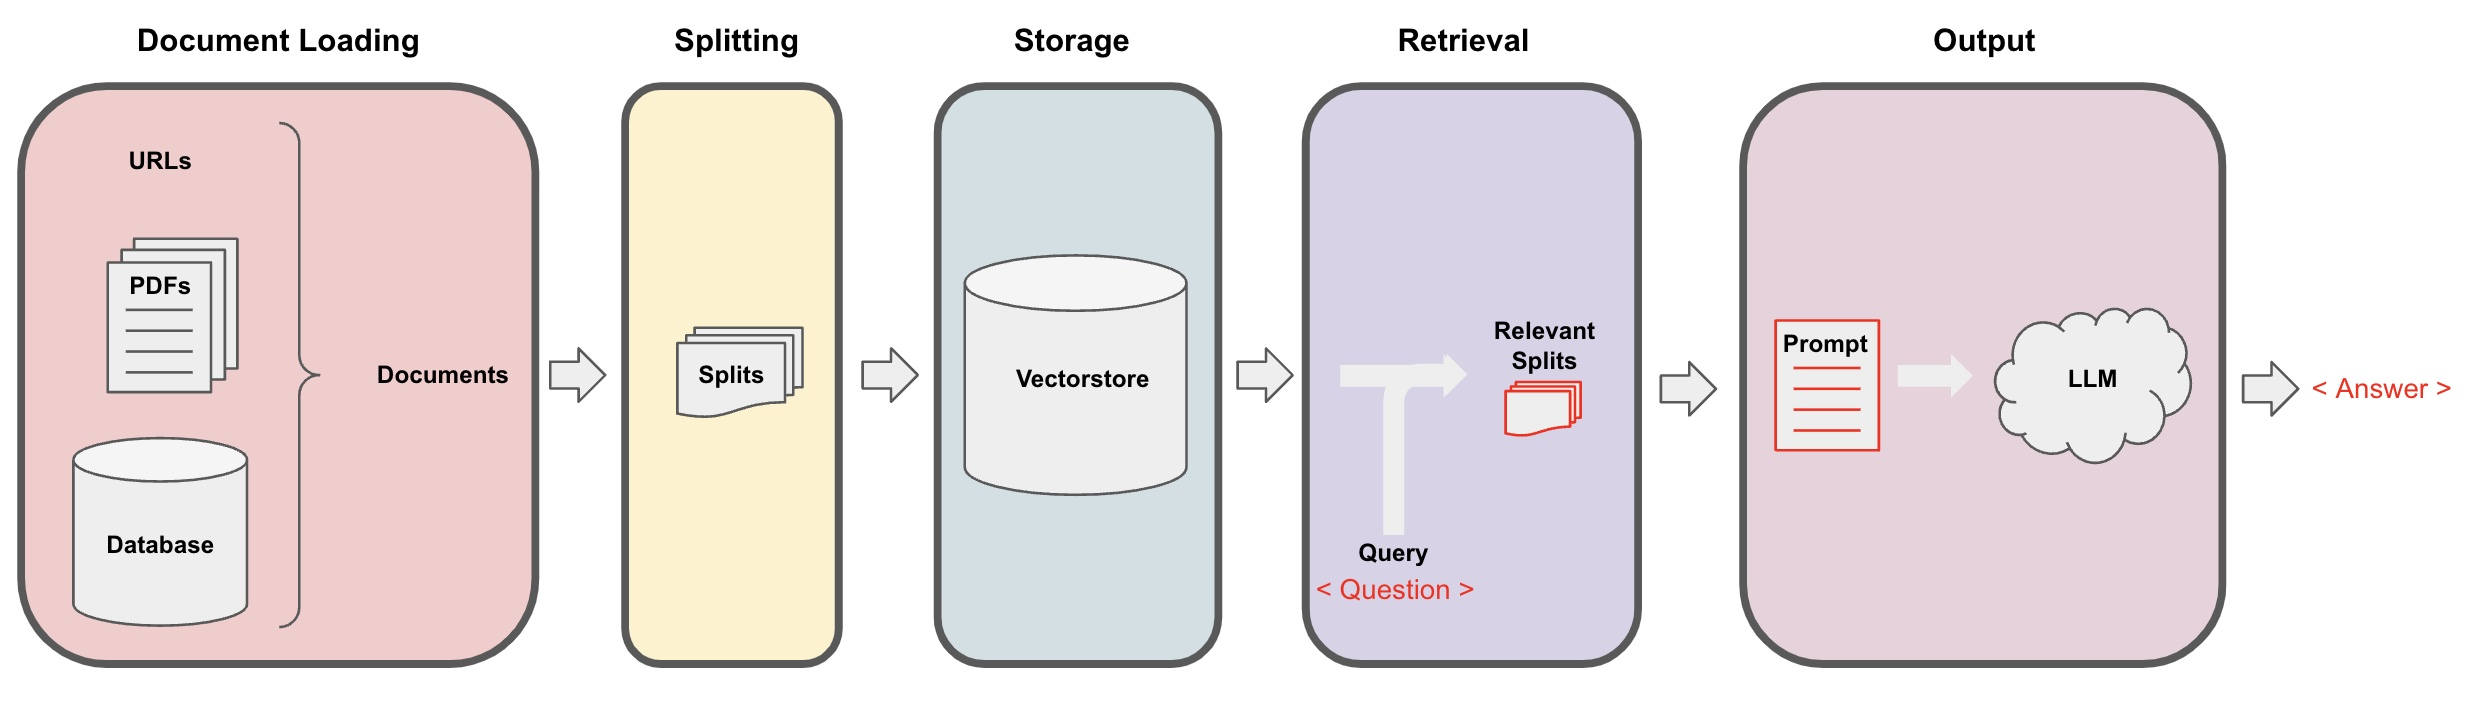

RAG Evaluation ([Evaluation framework](https://github.com/explodinggradients/ragas))
- Feithfulness
- Context recall
- Context precision
- Context relevancy
- Answer  relevancy.

## Question Answering on PubMed articles
Environment setup including LangChain

In [ ]:
!pip install -q --upgrade pip
!pip install -q --upgrade langchain
!pip install -q --upgrade datasets

# restart session after installing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.0/817.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.4/246.4 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00


Formatting output

In [ ]:
#Wrap output
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

PubMed has 35 million abstracts that will generate approximately 100 million chuncks (100 millions embeddings) then 25 billion tokens (considering 250 tokens per segment). Cost estimate for a Vector DB managed service would be 7-8 K USD excluding storage. We then need to add the cost to generate the embedding (100 K USD) and the monthly cost to handle the queries.

Let's download 1000 abstract articles from PubMed diabetes related already cllected as csv:

In [ ]:
! wget -P ./data -q https://raw.githubusercontent.com/saurograndi/healthcare_nlp/main/data/pubmed_diabetes_1000_meta.csv

In [ ]:
import pandas as pd

df = pd.read_csv('data/pubmed_diabetes_1000_meta.csv')

In [ ]:
df.head(5)

,seq,pubmed_id,abstract,pubdate,title,fulljournalname
0,0,PMC3312572,The pituitary gland and infundibulum can be in...,2012 Mar 18,Metastatic Prostate Adenocarcinoma Presenting ...,Case Reports in Medicine
1,1,PMC7730786,Current evidence suggests that the information...,2020 Dec 10,Different information needs in subgroups of pe...,BMC Public Health
2,2,PMC6913526,Ethnic minority populations exhibit disproport...,2019 Oct 16,"Development and Efficacy of an Electronic, Cul...",Journal of Medical Internet Research
3,3,PMC4653349,"Recently, imbalance in the vasopressin (AVP) s...",2016 Jan,Genetic vasopressin 1b receptor variance in ov...,European Journal of Endocrinology
4,4,PMC8606862,Deterioration in glucose homeostasis has been ...,2021 Nov 21,Progression of diabetes is associated with cha...,Physiological Reports


Document Loading:

In [ ]:
from langchain.document_loaders import DataFrameLoader
from langchain.vectorstores import DocArrayInMemorySearch

loader = DataFrameLoader(df, page_content_column='abstract')
documents = loader.load()
documents[2]

Document(page_content='Ethnic minority populations exhibit disproportionately high rates of type 2 diabetes mellitus (T2DM). Electronic health tools have the potential to facilitate the cultural adaptation and tailoring of T2DM education to improve the knowledge and management of diabetes mellitus (DM).\nThis study aimed (1) to develop an adaptable Interactive Lifestyle Assessment, Counseling, and Education (I-ACE) software to support dietitian-delivered lifestyle counseling among low-socioeconomic status (SES) ethnic minority patients with T2DM and (2) to evaluate its effect on DM-related dietary knowledge and management compared with standard lifestyle advice (SLA) in a randomized controlled trial (RCT).\nThe I-ACE software, developed in consultation with clinical dieticians, incorporates evidence-based dietary and physical activity (PA) recommendations and educational materials. The features and behavioral change techniques include quantitative lifestyle (dietary intake and PA) asse

In [ ]:
print(f'Number of documents: {len(documents)}')
print(f'Length of first document abstract: {len(documents[0].page_content)}')

Number of documents: 1000
Length of first document abstract: 1207


Document Splitting:

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50,
    separators=["\n\n", "\n", "(?<=\. )", " ", ""]
)

texts = r_splitter.split_documents(documents)

print(f'Number of splits: {len(texts)}\n')
for i in range(3):
  print(f'Split #{i}:\n{texts[i]}\n')

Number of splits: 4498

Split #0:
page_content='The pituitary gland and infundibulum can be involved in a variety of medical conditions, including infiltrative diseases, fungal infections, tuberculosis, and primary and metastatic tumors. Metastases to the pituitary gland are absolutely rare, and they are generally secondary to pulmonary carcinoma in men and breast carcinoma in women. Pituitary metastases more commonly affect the posterior lobe and the infundibulum than the anterior lobe. The posterior lobe involvement may explain why patients' metadata={'seq': 0, 'pubmed_id': 'PMC3312572', 'pubdate': '2012 Mar 18', 'title': 'Metastatic Prostate Adenocarcinoma Presenting Central Diabetes Insipidus', 'fulljournalname': 'Case Reports in Medicine'}

Split #1:
page_content='lobe involvement may explain why patients with pituitary metastases frequently present with diabetes insipidus. We are presenting a case report of a 78-year-old male patient who had metastatic prostate with sudden onset 

In [ ]:
print(f'Number of chuncks: {len(texts)}')

Number of chuncks: 4498


RecursiveCharacterTextSplitter does not preserve semantic. Looking at e.g. abstract PMC6308908, we can notice that statement related to diabetes is split into 2 chunks in order not to exceed 500 characters of max_len:

In [ ]:
for i in range(len(texts)):
  if("relevant pathway in human patients suffering from diabetes" in texts[i].page_content):
    print(f'Split #{i-1}, len {len(texts[i-1].page_content)}:\n{texts[i-1]}\n')
    print(f'Split #{i}, len {len(texts[i].page_content)}:\n{texts[i]}\n')
    print(f'Split #{i+1}, len {len(texts[i+1].page_content)}:\n{texts[i+1]}\n')

Split #3422, len 495:
page_content='Glo1−/− mice were viable and showed no elevated MG or MG-H1 levels under hyperglycemic conditions. It was subsequently found that the enzymatic efficiency of various oxidoreductases in the liver and kidney towards MG were increased in the Glo1−/− mice. The functional relevance of this was supported by the altered distribution of alternative detoxification products. Furthermore, it was shown that MG-dependent AKR activity is a potentially clinical relevant pathway in human patients suffering' metadata={'seq': 761, 'pubmed_id': 'PMC6308908', 'pubdate': '2018 Sep 19', 'title': 'Compensatory mechanisms for methylglyoxal detoxification in experimental & clinical diabetes', 'fulljournalname': 'Molecular Metabolism'}

Split #3423, len 59:
page_content='relevant pathway in human patients suffering from diabetes.' metadata={'seq': 761, 'pubmed_id': 'PMC6308908', 'pubdate': '2018 Sep 19', 'title': 'Compensatory mechanisms for methylglyoxal detoxification in ex

If we remove " " and "" from the separators list the sentence is not split into 2 chuncks, but the 500 chars max length is not assured:

In [ ]:
r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50,
    separators=["\n\n", "\n", "(?<=\. )"]
)

texts = r_splitter.split_documents(documents)

print(f'Number of splits: {len(texts)}\n')

for i in range(len(texts)):
  if("relevant pathway in human patients suffering from diabetes" in texts[i].page_content):
    print(f'Split #{i-1}, len {len(texts[i-1].page_content)}:\n{texts[i-1]}\n')
    print(f'Split #{i}, len {len(texts[i].page_content)}:\n{texts[i]}\n')
    print(f'Split #{i+1}, len {len(texts[i+1].page_content)}:\n{texts[i+1]}\n')

Number of splits: 2481

Split #1874, len 192:
page_content='CRISPR/Cas9-mediated genome editing was used to generate a Glo1 knock-out (Glo1−/−) mouse line. Streptozotocin was then applied to investigate metabolic changes under hyperglycemic conditions.' metadata={'seq': 761, 'pubmed_id': 'PMC6308908', 'pubdate': '2018 Sep 19', 'title': 'Compensatory mechanisms for methylglyoxal detoxification in experimental & clinical diabetes', 'fulljournalname': 'Molecular Metabolism'}

Split #1875, len 511:
page_content='\nGlo1−/− mice were viable and showed no elevated MG or MG-H1 levels under hyperglycemic conditions. It was subsequently found that the enzymatic efficiency of various oxidoreductases in the liver and kidney towards MG were increased in the Glo1−/− mice. The functional relevance of this was supported by the altered distribution of alternative detoxification products. Furthermore, it was shown that MG-dependent AKR activity is a potentially clinical relevant pathway in human patient

### Embedding - Hugging Face

Hugging Face [Embedding leaderboard](https://huggingface.co/spaces/mteb/leaderboard)

In [ ]:
!pip install -q InstructorEmbedding
!pip install -q sentence_transformers==2.2.2
!pip install -q langchain_experimental

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.6/171.6 kB 1.6 MB/s eta 0:00:00


In [ ]:
from langchain.embeddings import HuggingFaceInstructEmbeddings

hf_embeddings = HuggingFaceInstructEmbeddings(
    model_name = "hkunlp/instructor-base",
    model_kwargs = {'device': 'cpu'}
)

/usr/local/lib/python3.10/dist-packages/InstructorEmbedding/instructor.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


.gitattributes:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/66.2k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.43k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

load INSTRUCTOR_Transformer


/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


max_seq_length  512


Let's try another splitter, the [SemanticChunker](https://python.langchain.com/docs/modules/data_connection/document_transformers/semantic-chunker):

In [ ]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_splitter = SemanticChunker(hf_embeddings)

texts = semantic_splitter.split_documents(documents)

print(f'Number of splits: {len(texts)}\n')

for i in range(len(texts)):
  if("relevant pathway in human patients suffering from diabetes" in texts[i].page_content):
    print(f'Split #{i-1}, len {len(texts[i-1].page_content)}:\n{texts[i-1]}\n')
    print(f'Split #{i}, len {len(texts[i].page_content)}:\n{texts[i]}\n')
    print(f'Split #{i+1}, len {len(texts[i+1].page_content)}:\n{texts[i+1]}\n')

Number of splits: 2002

Split #1522, len 497:
page_content='The deficit of Glyoxalase I (Glo1) and the subsequent increase in methylglyoxal (MG) has been reported to be one the five mechanisms by which hyperglycemia causes diabetic late complications. Aldo-keto reductases (AKR) have been shown to metabolize MG; however, the relative contribution of this superfamily to the detoxification of MG in\xa0vivo, particularly within the diabetic state, remains unknown. CRISPR/Cas9-mediated genome editing was used to generate a Glo1 knock-out (Glo1−/−) mouse line.' metadata={'seq': 761, 'pubmed_id': 'PMC6308908', 'pubdate': '2018 Sep 19', 'title': 'Compensatory mechanisms for methylglyoxal detoxification in experimental & clinical diabetes', 'fulljournalname': 'Molecular Metabolism'}

Split #1523, len 936:
page_content='Streptozotocin was then applied to investigate metabolic changes under hyperglycemic conditions. Glo1−/− mice were viable and showed no elevated MG or MG-H1 levels under hypergly

### Vector Database - Chromadb

In [ ]:
!pip install -q chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.0/509.0 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 698.9/698.9 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from langchain.vectorstores import Chroma
persist_directory = 'db/chroma/'

#!rm -rf ./db/chroma

In [ ]:
# To create vector db (first time)
#%%time

#chroma_vdb = Chroma.from_documents(
#    documents=texts,
#    embedding=hf_embeddings,
#    persist_directory=persist_directory
#)

In [ ]:
# save to disk

#chroma_vdb.persist()

In [ ]:
# Compress vector database directory
#!zip -r chroma_vdb.zip ./db/chroma

In [ ]:
# Delete vector database directory
!rm -rf db/chroma

# Download preloaded database from git repo
! wget -q https://raw.githubusercontent.com/saurograndi/healthcare_nlp/main/data/chroma_vdb.zip

!unzip chroma_vdb.zip

Archive:  chroma_vdb.zip
   creating: db/chroma/
   creating: db/chroma/264e3cef-3149-45b5-9f4d-30eb6cf32811/
  inflating: db/chroma/264e3cef-3149-45b5-9f4d-30eb6cf32811/length.bin  
  inflating: db/chroma/264e3cef-3149-45b5-9f4d-30eb6cf32811/data_level0.bin  
  inflating: db/chroma/264e3cef-3149-45b5-9f4d-30eb6cf32811/link_lists.bin  
  inflating: db/chroma/264e3cef-3149-45b5-9f4d-30eb6cf32811/header.bin  
  inflating: db/chroma/264e3cef-3149-45b5-9f4d-30eb6cf32811/index_metadata.pickle  
  inflating: db/chroma/chroma.sqlite3  
   creating: db/chroma/8f7b96ba-36db-49d4-9883-b52dfd10ddf3/


In [ ]:
%%time

chroma_vdb = Chroma(
    embedding_function=hf_embeddings,
    persist_directory=persist_directory
)

CPU times: user 7.6 ms, sys: 889 µs, total: 8.49 ms
Wall time: 29 ms


In [ ]:
query = "causes of diabetes"

docs = chroma_vdb.similarity_search(query, k=2)
docs

[Document(page_content='relevant pathway in human patients suffering from diabetes.', metadata={'fulljournalname': 'Molecular Metabolism', 'pubdate': '2018 Sep 19', 'pubmed_id': 'PMC6308908', 'seq': 761, 'title': 'Compensatory mechanisms for methylglyoxal detoxification in experimental & clinical diabetes'}),
 Document(page_content='diabetes-related comorbidities, and well-being.', metadata={'fulljournalname': 'BMC Public Health', 'pubdate': '2020 Dec 10', 'pubmed_id': 'PMC7730786', 'seq': 1, 'title': 'Different information needs in subgroups of people with diabetes mellitus: a latent class analysis'})]

In [ ]:
# Standard retriever with similarity
retriever = chroma_vdb.as_retriever(search_kwargs={'k' : 10})
results = retriever.get_relevant_documents(query)

# Retriever with Maximal Marginal relevance
retriever_mmr = chroma_vdb.as_retriever(search_type='mmr', search_kwargs={'k' : 10, 'lambda_mult' : 0.25})
results_mmr = retriever_mmr.get_relevant_documents(query)

print(f'Simple similarity search:\n{results}\n')
print(f'Similarity search with MMN:\n{results_mmr}')

Simple similarity search:
[Document(page_content='relevant pathway in human patients suffering from diabetes.', metadata={'fulljournalname': 'Molecular Metabolism', 'pubdate': '2018 Sep 19', 'pubmed_id': 'PMC6308908', 'seq': 761, 'title': 'Compensatory mechanisms for methylglyoxal detoxification in experimental & clinical diabetes'}), Document(page_content='diabetes-related comorbidities, and well-being.', metadata={'fulljournalname': 'BMC Public Health', 'pubdate': '2020 Dec 10', 'pubmed_id': 'PMC7730786', 'seq': 1, 'title': 'Different information needs in subgroups of people with diabetes mellitus: a latent class analysis'}), Document(page_content='Background: Diabetes is referred to a group of diseases characterized by high glucose levels in blood. It is caused by a deficiency in the production or function of insulin or both, which can occur because of different reasons, resulting in protein and lipid metabolic disorders. The aim of this study was to systematically review the preval

In [ ]:
results[0]

Document(page_content='relevant pathway in human patients suffering from diabetes.', metadata={'fulljournalname': 'Molecular Metabolism', 'pubdate': '2018 Sep 19', 'pubmed_id': 'PMC6308908', 'seq': 761, 'title': 'Compensatory mechanisms for methylglyoxal detoxification in experimental & clinical diabetes'})

In [ ]:
print('Simple similarity search:')
pd.DataFrame([doc.metadata for doc in results])

Simple similarity search:


,fulljournalname,pubdate,pubmed_id,seq,title
0,Molecular Metabolism,2018 Sep 19,PMC6308908,761,Compensatory mechanisms for methylglyoxal deto...
1,BMC Public Health,2020 Dec 10,PMC7730786,1,Different information needs in subgroups of pe...
2,Health Promotion Perspectives,2020 Mar 30,PMC7146037,7,Prevalence and incidence of type 1 diabetes in...
3,BMC Public Health,2019 Oct 15,PMC6794810,204,Association of genetic and behavioral characte...
4,Journal of Diabetes Investigation,2020 Jan 13,PMC7378450,787,Association between mean platelet volume in th...
5,Frontiers in Endocrinology,2021 Mar 11,PMC7992003,293,Aldose Reductase: An Emerging Target for Devel...
6,BMC Public Health,2020 Dec 10,PMC7730786,1,Different information needs in subgroups of pe...
7,BMJ Open Diabetes Research & Care,2022 Jan 25,PMC8796247,983,Need for improved diabetes support among peopl...
8,Human Mutation,2020 Feb 17,PMC7187370,616,Update of variants identified in the pancreati...
9,Human Mutation,2020 Feb 17,PMC7187370,616,Update of variants identified in the pancreati...


In [ ]:
print('Similarity search with MMN')
pd.DataFrame([doc.metadata for doc in results_mmr])

Similarity search with MMN


,fulljournalname,pubdate,pubmed_id,seq,title
0,Molecular Metabolism,2018 Sep 19,PMC6308908,761,Compensatory mechanisms for methylglyoxal deto...
1,BMC Public Health,2019 Oct 15,PMC6794810,204,Association of genetic and behavioral characte...
2,Human Mutation,2020 Feb 17,PMC7187370,616,Update of variants identified in the pancreati...
3,Heliyon,2021 May 21,PMC8165422,839,Meta-analysis of studies on depression prevale...
4,Diabetic Medicine,2016 Aug 25,PMC5411261,943,Trends in diabetes and obesity in Samoa over 3...
5,Diabetes & Metabolism Journal,2020 Oct 21,PMC7643597,868,Update on Monogenic Diabetes in Korea
6,International Journal of Molecular Sciences,2020 Jul 12,PMC7403998,86,The Impact of Diabetes Mellitus on Cardiovascu...
7,Medical Science Monitor : International Medica...,2019 Jul 11,PMC6642671,196,The Association Between the rs2975760 and rs37...
8,Diabetes & Vascular Disease Research,2021 Apr 29,PMC8482730,30,Coronary revascularization in patients with st...
9,Frontiers in Endocrinology,2021 Jun 17,PMC8247904,580,COVID-19 and Diabetes: Understanding the Inter...


## LLM

### Local LLMs

As a reminder:
- Decoder-only models run inference with the `text-generation` pipeline.
- Encoder-decoder needs a `text2text-generation` pipeline.
Possible tasks to specify in the promps: Sentiment, Named entities, Translation, Summary, Answer.

The following models will be tested:

[GPT3.5 at OpenAI](https://platform.openai.com/docs/models/gpt-3-5-turbo)

- **gpt-3.5-turbo-16k**: 175 B parameters, max context length (conect window) 16K tokens

[Flan-T5 at Hugging Face](https://huggingface.co/google/flan-t5-small),
 [Flan-T5 Research paper](https://arxiv.org/pdf/2210.11416.pdf)

- **flan-t5-small**: 80 M parameters, max sequence length is 512
- **flan-t5-large**: 700 M parameters, dimension is 512
- **flan-t5-xl**: 3 B parameters
- **flan-t5-xxl**: 11 B parameters
Look at Flan-PaLM decoder-only (8B-540B)

[GPT2 at Hugging Face](https://huggingface.co/openai-community/gpt2)

- **gpt2**:  512 M parameters, dimension is 1024

[Llama-2-7B cpp](https://huggingface.co/TheBloke/Llama-2-7B-Chat-GGUF)

- **Llama-2-7B**: 7 B parameters

[zephyr-7B-beta cpp](https://huggingface.co/TheBloke/zephyr-7B-beta-GGUF)

- **zephyr-7B-beta**: 7 B parameters

-----
https://arxiv.org/pdf/2306.08302.pdf

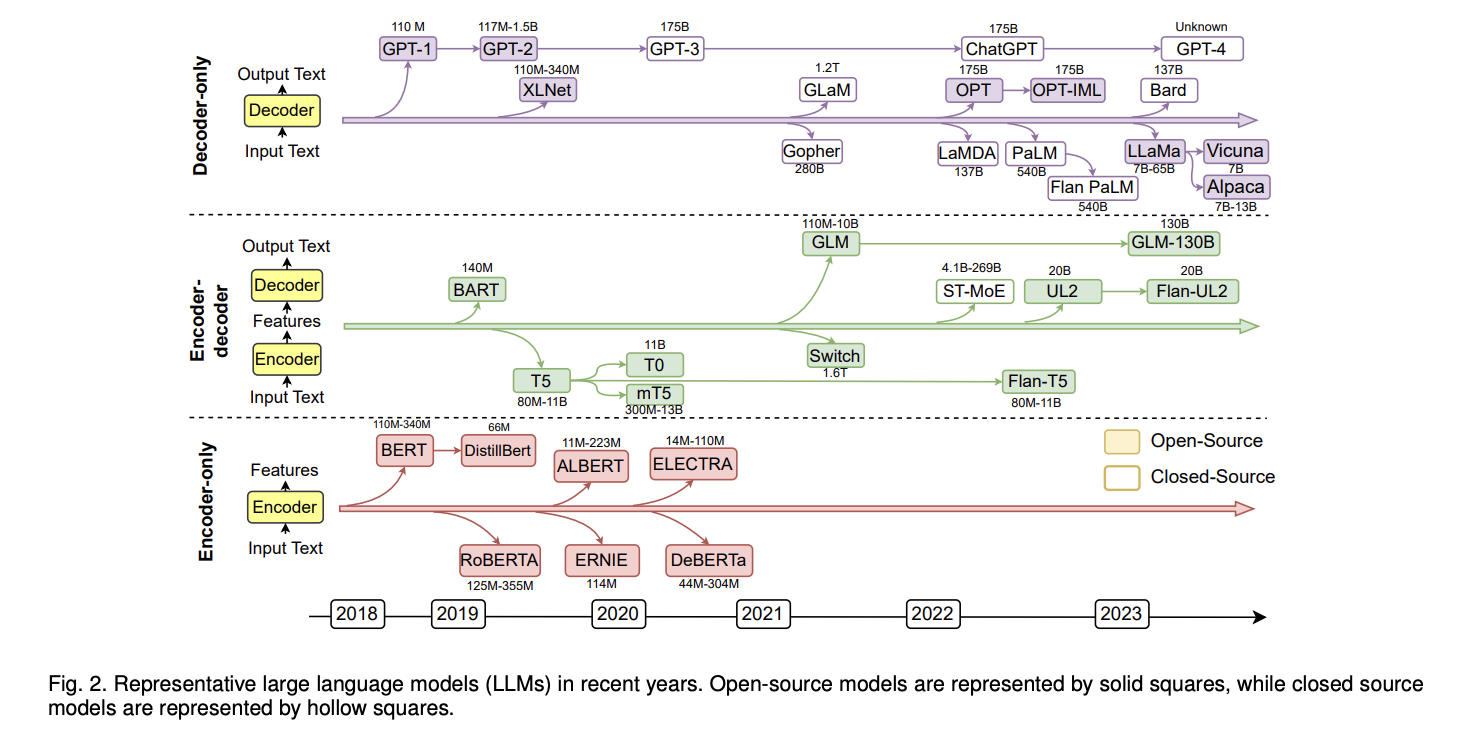

### LLM - OpenAI

LLL should be selected according to `Context Adherence Score` to avoid allucination (look at [LLM Hallucination Index](https://www.rungalileo.io/hallucinationindex)).

In [ ]:
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

In [ ]:
!pip install -q --upgrade openai
!pip install -q --upgrade langchain-openai

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA # completion llm
llm = ChatOpenAI( openai_api_key=OPENAI_API_KEY, model_name='gpt-3.5-turbo-16k', temperature=0.0 )

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [ ]:
from langchain.prompts import PromptTemplate
new_template = """
Use the following pieces of context to answer the user's question. If you return an answer, end with 'It's my pleasure'. If you don't know the answer, just say that you don't know, don't try to make up an answer .
{context} Question: {question}
Helpful Answer:"""

QA_CHAIN_PROMPT = PromptTemplate.from_template(new_template)

In [ ]:
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=retriever,
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

qa_chain_mmr = RetrievalQA.from_chain_type(
    llm,
    retriever=retriever_mmr,
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

question = "The causes for diabetes?"
result = qa_chain({"query": question})
result_mmr = qa_chain_mmr({"query": question})

print(f'Standard retriever:\n{result["result"]}\n')
print(f'MMR retriever\n{result_mmr["result"]}')

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


Standard retriever:
The causes for diabetes can vary and may include factors such as genetic predisposition, lifestyle choices, and certain medical conditions. It's important to note that there are different types of diabetes, including type 1 and type 2, and the specific causes can differ between them. It's best to consult with a healthcare professional for a comprehensive understanding of the causes and risk factors for diabetes. It's my pleasure to assist you.

MMR retriever
The causes for diabetes include a combination of genetic and lifestyle factors. It is believed that both genetic characteristics and certain lifestyle choices can contribute to the development of diabetes. However, the exact causes of diabetes are still not fully understood and further research is needed to fully understand the underlying mechanisms. It's my pleasure to help!


In [ ]:
pd.DataFrame([doc.metadata for doc in result['source_documents']])

,fulljournalname,pubdate,pubmed_id,seq,title
0,Molecular Metabolism,2018 Sep 19,PMC6308908,761,Compensatory mechanisms for methylglyoxal deto...
1,Health Promotion Perspectives,2020 Mar 30,PMC7146037,7,Prevalence and incidence of type 1 diabetes in...
2,BMC Public Health,2020 Dec 10,PMC7730786,1,Different information needs in subgroups of pe...
3,BMC Public Health,2019 Oct 15,PMC6794810,204,Association of genetic and behavioral characte...
4,Frontiers in Endocrinology,2021 Mar 11,PMC7992003,293,Aldose Reductase: An Emerging Target for Devel...
5,Heliyon,2021 May 21,PMC8165422,839,Meta-analysis of studies on depression prevale...
6,BMC Public Health,2020 Dec 10,PMC7730786,1,Different information needs in subgroups of pe...
7,Journal of Diabetes Investigation,2020 Jan 13,PMC7378450,787,Association between mean platelet volume in th...
8,Human Mutation,2020 Feb 17,PMC7187370,616,Update of variants identified in the pancreati...
9,Human Mutation,2020 Feb 17,PMC7187370,616,Update of variants identified in the pancreati...


In [ ]:
pd.DataFrame([doc.metadata for doc in result_mmr['source_documents']])

,fulljournalname,pubdate,pubmed_id,seq,title
0,Molecular Metabolism,2018 Sep 19,PMC6308908,761,Compensatory mechanisms for methylglyoxal deto...
1,BMC Public Health,2019 Oct 15,PMC6794810,204,Association of genetic and behavioral characte...
2,Frontiers in Endocrinology,2021 Mar 11,PMC7992003,293,Aldose Reductase: An Emerging Target for Devel...
3,International Journal of Molecular Sciences,2020 Jul 12,PMC7403998,86,The Impact of Diabetes Mellitus on Cardiovascu...
4,Bioscience Reports,2020 Sep 10,PMC7494983,252,Epigenetic modification and therapeutic target...
5,Human Mutation,2020 Feb 17,PMC7187370,616,Update of variants identified in the pancreati...
6,International Journal of Environmental Researc...,2021 Oct 21,PMC8582904,856,Association between Dietary Habits and Type 2 ...
7,The Nucleus,2021 Oct 5,PMC8491600,65,"Diabetes: discovery of insulin, genetic, epige..."
8,Cureus,2020 Aug 25,PMC7521466,321,Pharmacological Primary Prevention of Diabetes...
9,Annals of General Psychiatry,2018 Oct 23,PMC6198430,968,Analysis of global research output on diabetes...


### LLM - Llama-2 (CTransformer)


In [ ]:
!pip install -q ctransformers

In [ ]:
from langchain.llms import CTransformers
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
llm = CTransformers(
    model="TheBloke/Llama-2-7B-Chat-GGUF",
    model_file = 'llama-2-7b-chat.Q4_0.gguf',
    model_type="llama",
    config={'temperature': 0.01,
            'max_new_tokens': 512,
            'context_length': 4096
            },
    callbacks=[StreamingStdOutCallbackHandler()]
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# max context = 4096

retriever_k3 = chroma_vdb.as_retriever(search_type="mmr", search_kwargs={'k': 3, 'lambda_mult': 0.25})

In [ ]:
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=retriever_k3,
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

question = "The causes for diabetes?"
result = qa_chain({"query": question})

print(result['result'])

 It's my pleasure to help you with that! Diabetes is a complex disease with multiple causes, including genetic, environmental, and lifestyle factors. In human patients suffering from diabetes, the following pathways have been implicated:
1. Insulin resistance: This is the most common cause of diabetes, where the body's cells become less responsive to insulin, a hormone produced by the pancreas that regulates blood sugar levels.
2. Pancreatic beta-cell dysfunction: The pancreas produces too little insulin or has difficulty producing enough insulin to meet the body's needs.
3. Genetic mutations: Some people are born with genetic mutations that affect the insulin production or insulin signaling pathways, leading to diabetes.
4. Obesity and weight gain: Excess body fat can lead to insulin resistance, making it harder for the body to regulate blood sugar levels.
5. Sedentary lifestyle: A lack of physical activity can also contribute to insulin resistance and increase the risk of developing 

In [ ]:
result['source_documents']

[Document(page_content='relevant pathway in human patients suffering from diabetes.', metadata={'fulljournalname': 'Molecular Metabolism', 'pubdate': '2018 Sep 19', 'pubmed_id': 'PMC6308908', 'seq': 761, 'title': 'Compensatory mechanisms for methylglyoxal detoxification in experimental & clinical diabetes'}),
 Document(page_content='The prevalence of diabetes mellitus is rising among children and adolescents worldwide. Cardiovascular diseases are the main cause of morbidity and mortality in diabetic patients. We review the impact of diabetes on establishing, during childhood and adolescence, the premises for cardiovascular diseases later in life. Interestingly, it seems that hyperglycemia is not the only factor that establishes an increased cardiovascular risk in adolescence. Other factors have been recognized to play a', metadata={'fulljournalname': 'International Journal of Molecular Sciences', 'pubdate': '2020 Jul 12', 'pubmed_id': 'PMC7403998', 'seq': 86, 'title': 'The Impact of Di

### LLM - Zephyr (CTransformers)

In [ ]:
from langchain.llms import CTransformers
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

llm = CTransformers(
    model="TheBloke/zephyr-7B-beta-GGUF",
    model_file = 'zephyr-7b-beta.Q4_0.gguf',
    model_type="mistral",
    temperature = 0.01,
    max_new_tokens = 512,
    context_length = 4096,
    # lib="avx2",
    callbacks=[StreamingStdOutCallbackHandler()]
)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=retriever_k3,
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

question = "The causes for diabetes?"
result = qa_chain({"query": question})

print(result['result'])

 While hyperglycemia is certainly a factor that establishes an increased cardiovascular risk in adolescence with diabetes, other factors have also been identified as contributing to this phenomenon. This review specifically discusses variants in ABCC8 and KCNJ11, which can lead to both normal glucose tolerance (the opposite phenotype of diabetes) and diabetes. The review explores the spectrum of phenotypes associated with these variants and their potential implications for treatment in individuals carrying pathogenic variants. It's my pleasure. While hyperglycemia is certainly a factor that establishes an increased cardiovascular risk in adolescence with diabetes, other factors have also been identified as contributing to this phenomenon. This review specifically discusses variants in ABCC8 and KCNJ11, which can lead to both normal glucose tolerance (the opposite phenotype of diabetes) and diabetes. The review explores the spectrum of phenotypes associated with these variants and their

In [ ]:
result['source_documents']

[Document(page_content='relevant pathway in human patients suffering from diabetes.', metadata={'fulljournalname': 'Molecular Metabolism', 'pubdate': '2018 Sep 19', 'pubmed_id': 'PMC6308908', 'seq': 761, 'title': 'Compensatory mechanisms for methylglyoxal detoxification in experimental & clinical diabetes'}),
 Document(page_content='The prevalence of diabetes mellitus is rising among children and adolescents worldwide. Cardiovascular diseases are the main cause of morbidity and mortality in diabetic patients. We review the impact of diabetes on establishing, during childhood and adolescence, the premises for cardiovascular diseases later in life. Interestingly, it seems that hyperglycemia is not the only factor that establishes an increased cardiovascular risk in adolescence. Other factors have been recognized to play a', metadata={'fulljournalname': 'International Journal of Molecular Sciences', 'pubdate': '2020 Jul 12', 'pubmed_id': 'PMC7403998', 'seq': 86, 'title': 'The Impact of Di

### T5-Flan vs GPT2 (Local model from HF)

In [ ]:
from langchain.llms import HuggingFacePipeline
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

model_id = 'google/flan-t5-small'

tokenizer_t5 = AutoTokenizer.from_pretrained(model_id)
print(f'Maximum Sequence Length: , {tokenizer_t5.model_max_length}')

model_t5 = AutoModelForSeq2SeqLM.from_pretrained(model_id)

pipeline_t5 = pipeline(
    "text2text-generation",
    model=model_t5,
    tokenizer=tokenizer_t5,
    max_length=500
)

local_llm_t5 = HuggingFacePipeline(pipeline=pipeline_t5)

Maximum Sequence Length: , 512


In [ ]:
from langchain.llms import HuggingFacePipeline
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

model_id = 'gpt2'

tokenizer_gpt2 = AutoTokenizer.from_pretrained(model_id)
print(f'Maximum Sequence Length: , {tokenizer_gpt2.model_max_length}')

model_gpt2 = AutoModelForCausalLM.from_pretrained(model_id)

pipeline_gpt2 = pipeline(
    "text-generation",
    model=model_gpt2,
    tokenizer=tokenizer_gpt2,
    max_length=500
)

local_llm_gpt2 = HuggingFacePipeline(pipeline=pipeline_gpt2)

Maximum Sequence Length: , 1024


In [ ]:
from langchain.chains import RetrievalQA

QA_CHAIN_PROMPT = PromptTemplate.from_template(new_template)
qa_chain_t5 = RetrievalQA.from_chain_type(
    local_llm_t5,
    retriever=retriever,
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

qa_chain_gpt2 = RetrievalQA.from_chain_type(
    local_llm_gpt2,
    retriever=retriever,
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

question = "The causes for diabetes?"
result_t5 = qa_chain_t5({"query": question})
result_gpt2 = qa_chain_gpt2({"query": question})


print(f'Answer with flan-t5-small:\n{result_t5["result"]}')
print(f'Answer with gpt2:\n{result_gpt2["result"]}')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Answer with flan-t5-small:
a deficiency in the production or function of insulin or both
Answer with gpt2:
 These diseases are caused by the metabolic processes that underlie insulin resistance and insulin resistance in humans. Those processes may be mediated through adipose tissue, lipose tissues, the blood-brain barrier, adipose membrane lipids which are synthesized by the pancreas and are activated by insulin signaling on the cellular level, and on the endothelium which has to be repressed, depending on physiological state, by the body. In this chapter, the term "type 1 diabetes" means that


In [ ]:
print(f'result with flan-t5-small:\n{result_t5}\n')
print(f'result with gpt2:\n{result_gpt2}')

result with flan-t5-small:
{'query': 'The causes for diabetes?', 'result': 'a deficiency in the production or function of insulin or both', 'source_documents': [Document(page_content='relevant pathway in human patients suffering from diabetes.', metadata={'fulljournalname': 'Molecular Metabolism', 'pubdate': '2018 Sep 19', 'pubmed_id': 'PMC6308908', 'seq': 761, 'title': 'Compensatory mechanisms for methylglyoxal detoxification in experimental & clinical diabetes'}), Document(page_content='Background: Diabetes is referred to a group of diseases characterized by high glucose levels in blood. It is caused by a deficiency in the production or function of insulin or both, which can occur because of different reasons, resulting in protein and lipid metabolic disorders. The aim of this study was to systematically review the prevalence and incidence of type 1 diabetes in the world.', metadata={'fulljournalname': 'Health Promotion Perspectives', 'pubdate': '2020 Mar 30', 'pubmed_id': 'PMC714603

## Cinical Guidelines as a Knowledge Base

In [ ]:
from datasets import load_dataset

dataset = load_dataset("epfl-llm/guidelines")

In [ ]:
import pandas as pd

guidelines_df = pd.DataFrame(dataset['train'][:100])
guidelines_df.drop(['raw_text'], inplace=True, axis=1)
guidelines_df.head()

,id,source,title,clean_text,url,overview
0,7a73f9287841533eeb11c025026322a23d519f2c,cco,None,# QUESTIONS Diagnosis/Staging\nWhat benefit to...,None,None
1,0ca6b1adf1e6c001dc70cd13be35a1e8a4c14839,cco,None,# GUIDELINE OBJECTIVES\nTo update clinical gui...,None,None
2,68984194848f42b555d2a3c9077ac7a1e53f976b,cco,None,# GUIDELINE OBJECTIVES\nTo make recommendation...,None,None
3,c80ad0d5ba1eee75e1702847d361abd6ce4bc7b0,cco,None,Evidence-Based Series 4-5 is CURRENT as of Nov...,None,None
4,7a09ab0610ecc9990db3362ca0b00a37a016acb4,cco,None,# GUIDELINE OBJECTIVES\nTo make recommendation...,None,None


In [ ]:
from langchain.document_loaders import DataFrameLoader
from langchain.vectorstores import FAISS

loader = DataFrameLoader(guidelines_df, page_content_column='clean_text')
documents = loader.load()
print(documents[0].page_content)

NameError: name 'guidelines_df' is not defined

In [ ]:
r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50,
    separators=["\n#"]
)

gudeline_texts = r_splitter.split_documents(documents)

print(f'Number of splits: {len(gudeline_texts)}\n')
for i in range(3):
  print(f'Split #{i}:\n{gudeline_texts[i]}\n')

Number of splits: 1737

Split #0:
page_content='# QUESTIONS Diagnosis/Staging\nWhat benefit to clinical management does positron emission tomography (PET) or positron emission tomography/computed tomography (PET/CT) contribute to the diagnosis or staging of head and neck cancer? What benefit to clinical management does PET or PET/CT contribute to the assessment of treatment response for head and neck cancer?\nWhat benefit to clinical management does PET or PET/CT contribute when recurrence of head and neck cancer is suspected but not proven? What benefit to clinical management does PET or PET/CT contribute to restaging at the time of documented recurrence for head and neck cancer? What is the role of PET when a solitary metastasis is identified at the time of recurrence and a metastectomy is being contemplated?\n' metadata={'id': '7a73f9287841533eeb11c025026322a23d519f2c', 'source': 'cco', 'title': 'None', 'url': 'None', 'overview': 'None'}

Split #1:
page_content='# TARGET POPULATION\

### Vector Database - FAISS

In [ ]:
!pip install -q faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 55.0 MB/s eta 0:00:00


In [ ]:
faiss_directory = 'db/faiss/'
!rm -rf faiss_directory

In [ ]:
%%time
from langchain.vectorstores import FAISS

# To create vector db (first time)
#guideline_db = FAISS.from_documents(gudeline_texts, hf_embeddings)
#guideline_db.save_local("./db/faiss/faiss_retriever_db_guidelines.vs")

CPU times: user 59 µs, sys: 0 ns, total: 59 µs
Wall time: 103 µs


In [ ]:
#guideline_db.save_local("./db/faiss/faiss_retriever_db_guidelines.vs")

In [ ]:
# Compress vector database directory
#!zip -r faiss_vdb.zip ./db/faiss

In [ ]:
! wget -q https://raw.githubusercontent.com/saurograndi/healthcare_nlp/main/data/faiss_vdb.zip

! unzip faiss_vdb.zip

guideline_db = FAISS.load_local("./db/faiss/faiss_retriever_db_guidelines.vs", hf_embeddings)

Archive:  faiss_vdb.zip
replace db/faiss/faiss_retriever_db_guidelines.vs/index.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
faiss_retriever_guideline = guideline_db.as_retriever(search_kwargs={"k": 3})

query = "causes of diabetes"
docs = faiss_retriever_guideline.get_relevant_documents(query, k=2)

docs

[Document(page_content='\n# Diabetes\nDiabetes is the seventh leading cause of death in the United States (104 ). CHD is two to four times more common and stroke is two to six times more common in persons who have diabetes than in persons who do not have diabetes (113 ). Diabetes can lead to blindness, kidney disease, and nerve damage (113 ). Non-insulin-dependent diabetes mellitus, which affects approximately 90% of persons who have diabetes, is often associated with obesity (114 ). Maintaining a desirable body weight through physical activity and modest caloric restriction is important in preventing diabetes and controlling its complications (114 ).\n', metadata={'id': '9694b3bf518b96437fd2b3ea2a3d88b0c53d6afd', 'source': 'cdc', 'title': 'None', 'url': 'None', 'overview': 'None'}),
 Document(page_content='# Coronary Heart Disease\nCHD kills more persons in the United States than any other disease does (1 ). Dietrelated risk factors for CHD include high blood cholesterol, high blood p

### OpenAI

In [ ]:
llm = ChatOpenAI( openai_api_key=OPENAI_API_KEY, model_name='gpt-3.5-turbo-16k', temperature=0.0 )

qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=faiss_retriever_guideline,
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

question = "What's the relationshp between diabetes and obesity?"
result = qa_chain({"query": question})
print(f'OpenAI answer:\n{result["result"]}\n')


OpenAI answer:
Diabetes and obesity are often associated with each other. Non-insulin-dependent diabetes mellitus, which affects the majority of people with diabetes, is often linked to obesity. Maintaining a desirable body weight through physical activity and modest caloric restriction is important in preventing diabetes and controlling its complications. It's my pleasure to assist you!



### Flan-T5-small vs GPT-2

In [ ]:
result_t5 = qa_chain_t5({"query": question})
result_gpt2 = qa_chain_gpt2({"query": question})


print(f'Answer with flan-t5-small:\n{result_t5["result"]}\n')
print(f'Answer with gpt2:\n{result_gpt2["result"]}')

Token indices sequence length is longer than the specified maximum sequence length for this model (798 > 512). Running this sequence through the model will result in indexing errors
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 787, but `max_length` is set to 500. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Answer with flan-t5-small:
a causal relationship

Answer with gpt2:
 There


### Flan-T5-large

In [ ]:
model_id = 'google/flan-t5-large'

tokenizer_t5 = AutoTokenizer.from_pretrained(model_id)
print(f'Maximum Sequence Length: , {tokenizer_t5.model_max_length}')

model_t5 = AutoModelForSeq2SeqLM.from_pretrained(model_id)

pipeline_t5 = pipeline(
    "text2text-generation",
    model=model_t5,
    tokenizer=tokenizer_t5,
    max_length=500
)

local_llm_t5 = HuggingFacePipeline(pipeline=pipeline_t5)

qa_chain_t5 = RetrievalQA.from_chain_type(
    local_llm_t5,
    retriever=faiss_retriever_guideline,
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

result_t5 = qa_chain_t5({"query": question})

print(f'Answer with flan-t5-large:\n{result_t5["result"]}')

Maximum Sequence Length: , 512


Token indices sequence length is longer than the specified maximum sequence length for this model (706 > 512). Running this sequence through the model will result in indexing errors


Answer with flan-t5-large:
It's my pleasure


### GPT-2-large

In [ ]:
model_id = 'gpt2-large'

tokenizer_gpt2_l = AutoTokenizer.from_pretrained(model_id)
print(f'Maximum Sequence Length: , {tokenizer_gpt2_l.model_max_length}')

model_gpt2_l = AutoModelForCausalLM.from_pretrained(model_id)

pipeline_gpt2_l = pipeline(
    "text-generation",
    model=model_gpt2_l,
    tokenizer=tokenizer_gpt2_l,
    max_length=500
)

local_gpt2_l = HuggingFacePipeline(pipeline=pipeline_gpt2_l)

qa_chain_gpt2_l = RetrievalQA.from_chain_type(
    local_gpt2_l,
    retriever=faiss_retriever_guideline,
    return_source_documents=True,
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

result_gpt2_l = qa_chain_gpt2_l({"query": question})

print(f'Answer with gpt2-large:\n{result_gpt2_l["result"]}')

Maximum Sequence Length: , 1024
